Last time I wrote about training the language models from scratch, you can find this post <a href="https://zablo.net/blog/post/training-roberta-from-scratch-the-missing-guide-polish-language-model/?utm_source=blog&utm_medium=link&utm_campaign=roberta_from_scratch">here</a>. Now it's time to take your pre-trained lamnguage model at put it into good use by fine-tuning it for real world problem, i.e text classification or sentiment analysis. In this post I will show how to take pre-trained language model and build **custom** classifier on top of it. As in the previous post - I cover all of the important parts in details and I point out possible mistakes.

Why custom model? There are two answers. First is that the fun in deep learning begins only when you can do something custom with your model. Experiments, experiments and more experiments! Second thing is that by implmenting some parts on your own, you gain better understaing of different parts of the modeling itself, but also the whole training/fine-tuning process.

## TL;DR
This post covers:
1. taking existing pre-trained language model and understanding it's output - here I use PolBERTa trained for Polish language
1. building **custom classification head** on top of the LM
1. using fast tokenizers to efficiently tokenize and pad input text as well as prepare attention masks 
1. preparing reproducible training code with PyTorch Lightning
1. finding good starting learning rate for the model
1. validating the trained model on PolEmo 2.0 dataset (benchmark for Polish language sentiment analysis with 4 classes)

The whole post is available as a Colab Notebook, linked below in *Additional links and resources* section.

## Libraries and preparation
In this post I will use pretty standard set of ML-related libraries, including: transformers & tokenizers from HuggingFace, PyTorch Lightning, pandas, scikit-learn and LR Finder.

In [ ]:
!pip install transformers tokenizers pytorch-lightning

After running the cell below, you will probably have to restart the notebook (one time only).

In [ ]:
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [ ]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead, pipeline, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'1.4.0'

## Understanding pre-trained language model input / outputs
In order to build your classifier on top of pre-trained language model you must first understand it outputs. Usually it requries reading the related paper or (if possible) reading the documentation / github code. Fortunately, it's easy for Transformers library - as the models are documented and the return value is described well. For my case (RoBERTa) the docs are here: https://huggingface.co/transformers/model_doc/roberta.html#robertamodel. 

We're interested what `RobertaForMaskedLM` returns. It this case, output format is the following:

```python
sequence_output, pooled_output, (hidden_states), (attentions)
```

Let's take a look at it ourselves:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("marrrcin/PolBERTa-base-polish-cased-v1")
model = AutoModelWithLMHead.from_pretrained("marrrcin/PolBERTa-base-polish-cased-v1")

We are actually interested only in base model, without the LM head which is:

In [ ]:
base_model = model.roberta

Let's see what does output look like by running the model forward pass with some input. We need to tokenize the input first:

In [ ]:
text = "Mówiąc otwarcie jesteście reliktami. Ilu wiedźminów jeszcze żyje? Kilku? Góra kilkunastu. Nie stanowicie k<mask>. Poza tym, Zakon nie każe sobie płacić za ratowanie ludzi od złego."
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Tokenizer returns `input_ids` which are the tokens of your input text. Then `token_type_ids` and `attention_mask` - first one is used when you use LM for next-sentence prediction task, second one is to tell the model which tokens are from your input text and which are just padding tokens.

For classification, you only need `input_ids` and `attention_mask` as token types are created on the fly by the internal model's forward function (<a href="https://github.com/huggingface/transformers/blob/f7dcf8fcea4d486544f221032625a97ad7dc5405/src/transformers/modeling_bert.py#L701" target="blank">source</a>).

Let's run the model. The `.unsqueeze(0)` is just to simulate batch processing (in this case, it will be batch size of 1).

In [ ]:
# sequence_output, pooled_output, (hidden_states), (attentions)
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape, out[1].shape

(torch.Size([1, 12, 768]), torch.Size([1, 768]))

We are interested only in first element of the tuple while building classifier as the second element is used for next-sentence prediction task and **it is literally said in the Transformers docs not to use it**:
> This output is usually *not* a good summary
of the semantic content of the input, you're often better with averaging or pooling
the sequence of hidden-states for the whole input sequence. [<a href="https://github.com/huggingface/transformers/blob/f7dcf8fcea4d486544f221032625a97ad7dc5405/src/transformers/modeling_bert.py#L658" target="blank">source</a>]

Output shape description:
<img src="./model-output.png"/>

Keep in mind that for bigger batch sizes you have to pad to either longest text's lenght or to model's max supported length (which usually for BERT-like models is `512`).

The second dimension contains internal representation of each of the input tokens, so for properly tokenized data, i.e:

In [ ]:
t = "Mówiąc otwarcie jesteście reliktami."
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 355, 304, 1748, 71, 12029, 28398, 807, 2578, 19022, 18, 2]
<s> Mówiąc otwarcie jesteście reliktami.</s>
Length: 12
torch.Size([12, 768])


Representation for each token is as follows:
* `0` = "&lt;s&gt;" token is represented by `token_representations[0]`
* `355` = " M" token is represented by `token_representations[1]`

and so on...

## Build custom classification head on top of LM
OK, we understand the model's output and sizes, now we can build custom classification head on top of it.
Have you found new awesome activation function? Or maybe you want to try-out different pooling methods to better fit your case? You're free to experiment. In this example, I will try out custom `Mish` activation function on top of straightforward classification head inspired by RoBERTa's original one (<a href="https://github.com/huggingface/transformers/blob/f7dcf8fcea4d486544f221032625a97ad7dc5405/src/transformers/modeling_roberta.py#L563" target="blank">source</a>) and DistilBERT's custom initialization. Because why not!

In [ ]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [ ]:
class PolBERTaSentimentModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states, _ = self.base_model(X, attention_mask=attention_mask)
        
        # here I use only representation of <s> token, but you can easily use more tokens,
        # maybe do some pooling / RNNs... go crazy here!
        return self.classifier(hidden_states[:, 0, :])

<span style="color:red;font-weight:bold;">Hint</span>
> As a sanity check, I encourage you to run forward pass of the model on dummy data to validate the code. It also better to do this on CPU, as the stack traces of potential exceptions will be more meaningful. Mysterious CUDA erros very often are caused by simple Python-level errors.

In [ ]:
classifier = PolBERTaSentimentModel(AutoModelWithLMHead.from_pretrained("marrrcin/PolBERTa-base-polish-cased-v1").roberta, 3)

In [ ]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0)
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0)

In [ ]:
classifier((X, attn))

tensor([[0.5643, 0.2237, 0.1142]], grad_fn=<AddmmBackward>)

The output is correct - we've run the model with batch size and expected 3 classes output (for CrossEntropyLoss).

## Preparing fast tokenizers to use with text dataset
When you prepare your dataset you have two options while implementing `Dataset` class: 

* return tokenized text and class in `__getitem__` function
* return just text and class in `__getitem__` function and implement `Collate` function - this function will be used by PyTorch DataLoader to prepare batches

Here I've chosen the second approach.

Default tokenizer loaded above (as for Transformers v2.5.1) uses Python implementation. In order to leverage full potential of parallel Rust tokenizers, we need to save the tokenizer's internal data and then create instance of fast tokenizer with it.

In [ ]:
!mkdir -p tokenizer

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/special_tokens_map.json',
 'tokenizer/added_tokens.json')

In [ ]:
!ls tokenizer

merges.txt  special_tokens_map.json  tokenizer_config.json  vocab.json


Once saved, implement `CollateFn` using fast tokenizers. As you can see, the whole batch can be tokenized in parallel and the tokenizer will also automatically return attention mask and pad input to max length of 512.

<span style="color:red;font-weight:bold;">Important!</span>
> Ensure that all of the special tokens are in appropriate places and their IDs come from the actual tokenizer you're using - they should not be hardcoded, as different models will have different IDs for padding, BOS, EOS and so on.

In [ ]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(max_length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels


## Getting data for classification
Here I use PolEmo 2.0 dataset, which is a benchmark for sentiment analysis task in Polish language.

In [ ]:
!wget -O dataset_conll.zip https://clarin-pl.eu/dspace/bitstream/handle/11321/710/dataset_conll.zip?sequence=1&isAllowed=y 

In [ ]:
!unzip -n dataset_conll.zip

Archive:  dataset_conll.zip


In [ ]:
train_path, val_path, test_path = [f"dataset_conll/all.text.{d}.txt" for d in ("train", "dev", "test")]
train_path, val_path, test_path

('dataset_conll/all.text.train.txt',
 'dataset_conll/all.text.dev.txt',
 'dataset_conll/all.text.test.txt')

This dataset has CSV-like format with `__label__` text being the separator. Don't ask.
Let's take a quick look at the data:

In [ ]:
df = pd.read_csv(train_path, sep="__label__", header=None, names=["text", "label"], engine="python")
df.head()

,text,label
0,Na samym wejściu hotel śmierdzi . W pokojach j...,meta_minus_m
1,Ze swoimi dziećmi ( 10 lat i 2 latka ) chodzę ...,meta_plus_m
2,Chciał em zestaw do podstawowych prac coś przy...,meta_minus_m
3,Drogie Mamy . Mam o tym laktatorze takie same ...,meta_minus_m
4,"własciwie nic się nie dowidział em , podczas b...",meta_minus_m


In [ ]:
df.label.unique()

array(['meta_minus_m', 'meta_plus_m', 'meta_zero', 'meta_amb'],
      dtype=object)

You will need mapping between text label and integer:

In [ ]:
label2int = {
  "meta_minus_m": 0,
  "meta_plus_m": 1,
  "meta_zero": 2,
  "meta_amb": 3
}

As you can see below, the Dataset itself is really simple as it returns only the text and label. The rest is handled by the `TokenizersCollateFn` above.

In [ ]:
class PolEmo2Dataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep="__label__", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

Sanity check:

In [ ]:
ds = PolEmo2Dataset(train_path)
ds[13]

('Była m przekonana , że w Sopocie jest jeden hotel , który może zapewnić najlepszą jakość , tym większe było moje zaskoczenie krótkim pobytem służbowym w Małej Anglii . Miała m okazję mieszkać w pięknym i wygodnym pokoju o bardzo wysokim standardzie . Przemiła obsługa , co jest kluczowe i często niesieciowe hotele nie potrafią sobie z tym poradzić , tutaj nie było takiego problemu . Bardzo przyjemna strefa wellness oraz spa . Doskonała restauracja śniadaniowa , przepięknie urządzona , śniadanie bez zarzutu i kawa . . doskonała , każdy kawosz zrozumie . Brak widoku na morze został zupełnie zrekompensowany . Polecam i mam nadzieję , że taki poziom już pozostanie . Dziękuję za miłe wspomnienia . ',
 1)

## Preparing reproducible training code with PyTorch Lightning
Most recently, PyTorch Lightning is my *go to* library for quick prototyping with PyTorch. You have clear API that is actually extension of the original PyTorch `nn.Module` one with all of the repeatable parts like training loop, validation loop, using GPUs, learning rate schedulers, gradient accumulation, tensorboard, checkpointing and many others handled for you.

There is only a thin API you have to implement, which is `pl.LightningModule`. Required parts are:
1. `__init__` to initialize custom variables in your model
1. `forward` same as you would do in `nn.Module` - here I wrap my model inside of the `pl.LightningModule` but you could as well implement it directly here
1. `training_step` - take care of the forward pass for the model and return loss
1. `validation_step` and `test_step` - same as above but for the different learning phases
1. `train_dataloader` - `DataLoader` for your training dataset
1. `val_dataloader` and `test_dataloader` - same as above but for the different learning phases
1. `configure_optimizers` - prepare optimizer and (optionally) LR scheudles

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = PolBERTaSentimentModel(AutoModelWithLMHead.from_pretrained("marrrcin/PolBERTa-base-polish-cased-v1").roberta, 4)
        self.loss = nn.CrossEntropyLoss()
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    PolEmo2Dataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]


### Hints and comments
* `hparams` from `__init__` is a `Namespace`-type object, which holds all of the models hyperparameters; PyTorch Lightning takes good care of them when checkpointing the model
* `*_step` functions can be implemented with the same method with argument
* `*_dataloader` functions can also be implemented in this way
* in `configure_optimizers` the line: `[{"scheduler": lr_scheduler, "interval": "step"}]` takes care of the step-based LR scheduler - it does LR warmup and then linear decay, implementation comes from Transformers library

The code above is fairly simple and we don't need anything more here. For more robust examples I send you to PyTorch Lightning docs.

## Finding good starting learning rate for the model
There is a method of approximating "good" learning rate for the training. I first encountered it in Fast.ai Deep Learning course. This approach is called `LR-Finder` and boils down to plotting loss of the training batch (starting from really small LR) while increasing learning rate up to the poit where the loss blows up. Then, the "good" LR is one of the values that appears when the Loss/Learning Rate curve is decreasing.

<span style="color:red;font-weight:bold;">Important!</span>
> Keep in mind that this method does not guarantee to provide good learning rate for every dataset. It's just a method discovered to often work in practice.

Here I use implementation for PyTorch from <a href="https://github.com/davidtvs/pytorch-lr-finder" target="blank">here</a> (installed at the top of this notebook).

You need to specify initial learning rate and number of steps. Other parameters are optional.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


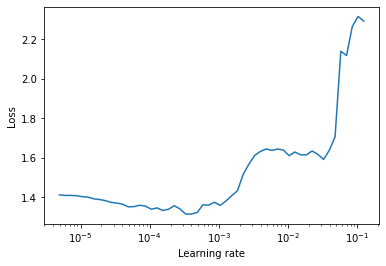

In [ ]:
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=8,
    warmup_steps=100,
    epochs=3,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7)
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

From the plot above we can guess that something between 1e-5 and 1e-4 would be a good learning rate, as everyhing higher results in increased loss.

To ensure the right spot was chosen, you can plot it:

In [ ]:
lr = 4e-5
lr

4e-05

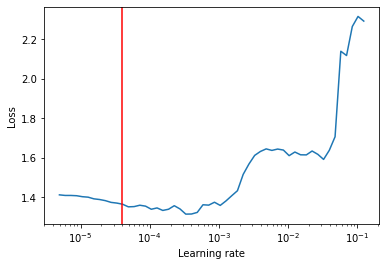

In [ ]:
lr_finder.plot(show_lr=lr)

## Training the sentiment analysis classifier on PolEmo2.0
We know the learning rate, we have the code for the model. Now it's time to run it.

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=8,
    warmup_steps=100,
    epochs=3,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [ ]:
# just to get rid of any leftovers before the training - useful when you run different cells multiple times
import gc; gc.collect()
torch.cuda.empty_cache()

### Using Trainer from PyTorch Lightning
The `pl.Trainer` provides all-in-one solution for training, validation and testing. There is a lot of useful parameters for almost every aspect of training you can think of, everything is well documented <a href="https://pytorch-lightning.readthedocs.io/en/0.7.1/trainer.html" target="blank">here</a>.

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

In [ ]:
trainer.fit(module)

1

## Evaluating the trained model
As this dataset is small, I've used scikit-learn to get the overall classification report from the model.

<span style="color:red;font-weight:bold;">Important!</span>
> Be aware that for big datasets this approach might not be optimal as it transfers the data from GPU to CPU for the whole dataset and puts every prediction in memory. For big datasets it's better to implement metrics inside of the `pl.LightningModule` when the dataset is processed in batches.

> Ensure that you disable gradients and put model into evaluation state (`module.eval()`) to disable dropouts during prediction.

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=6))


\
________________________________________________________________________________
              precision    recall  f1-score   support

meta_minus_m   0.880878  0.828909  0.854103       339
 meta_plus_m   0.867521  0.894273  0.880694       227
   meta_zero   0.957983  0.966102  0.962025       118
    meta_amb   0.574324  0.625000  0.598592       136

    accuracy                       0.832927       820
   macro avg   0.820177  0.828571  0.823854       820
weighted avg   0.837433  0.832927  0.834617       820



## Additional links and resources
* this notebook in Google Colab - 
* this notebook on GitHub - 
* PyTorch Lightning documentation - <a href="https://pytorch-lightning.readthedocs.io/en/0.7.1/" target="blank">https://pytorch-lightning.readthedocs.io/en/0.7.1/</a>